# 1. Importing the necessary dependencies

In [1]:
# Importing the dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score

import nltk
import re

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences,to_categorical
from keras.models import Sequential
from keras.layers import Dense,Embedding,SimpleRNN,LSTM,GRU,Bidirectional

import warnings
warnings.filterwarnings('ignore')  # To ignore warnings

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
train_data = pd.read_csv("train.txt",sep=";",names=["text","label"]) # Importing the train dataset
test_data = pd.read_csv("test.txt",sep=";",names=["text","label"])   # Importing the test dataset
validation_data = pd.read_csv("val.txt",sep=";",names=["text","label"])  # Importing the validation dataset

# 2. Performing the Data Analysis

In [3]:
print("Train data :\n",train_data.head(),"\n")  # Printing the train dataset
print("Test data :\n",test_data.head(),"\n")   # Printing the test dataset
print("Validation data :\n",validation_data.head(),"\n")  # Printing the validation dataset

Train data :
                                                 text    label
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger 

Test data :
                                                 text    label
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness 

Validation data :
                                                 text    label
0  im feeling quite sad and sorry for myself but ...  sadness
1  i feel like i am still looking at a blank canv...  sadness
2                   

In [4]:
print("Train Data shape: ",train_data.shape) #Printing the shape train data
print("Test Data shape: ",test_data.shape) #Printing the shape test data
print("Validation Data shape: ",validation_data.shape) #Printing the shape validation data

Train Data shape:  (16000, 2)
Test Data shape:  (2000, 2)
Validation Data shape:  (2000, 2)


In [5]:
## Performing the EDA for the training dataset only
print(train_data.info()) # Information about training dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB
None


In [6]:
print(train_data.describe()) # Describeing the numerical data of training dataset

                                                     text  label
count                                               16000  16000
unique                                              15969      6
top     i feel on the verge of tears from weariness i ...    joy
freq                                                    2   5362


In [7]:
print(train_data.describe(include = 'O')) # Describeing the non-numerical data of training dataset

                                                     text  label
count                                               16000  16000
unique                                              15969      6
top     i feel on the verge of tears from weariness i ...    joy
freq                                                    2   5362


In [8]:
train_data['label'].value_counts() # Counting the number of positive and negative sentiments of the training dataset

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

In [9]:
train_data['label'] = train_data['label'].map({
    'joy' : 0,
    'sadness': 1,
    'anger': 2,
    'fear': 3,
    'love': 4,
    'surprise':5
})
train_data.head()

test_data['label'] = test_data['label'].map({
    'joy' : 0,
    'sadness': 1,
    'anger': 2,
    'fear': 3,
    'love': 4,
    'surprise':5
})
test_data.head()

validation_data['label'] = validation_data['label'].map({
    'joy' : 0,
    'sadness': 1,
    'anger': 2,
    'fear': 3,
    'love': 4,
    'surprise':5
})
train_data.head()

,text,label
0,i didnt feel humiliated,1
1,i can go from feeling so hopeless to so damned...,1
2,im grabbing a minute to post i feel greedy wrong,2
3,i am ever feeling nostalgic about the fireplac...,4
4,i am feeling grouchy,2


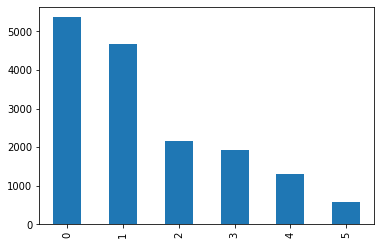

In [10]:
train_data['label'].value_counts().plot(kind = 'bar') # Plotting the bar plot for visualizing the countness of positive and negative labels
plt.show()

# 3. Feature Engineering

In [11]:
print("The Null value rows present in the trianing dataset is : ",train_data.isna().sum())    # Printing the null value present in the training dataset
print("The Duplicate rows present in the training dataset is : ",train_data.duplicated().sum())   # Printing the duplicated value present in the training dataset

The Null value rows present in the trianing dataset is :  text     0
label    0
dtype: int64
The Duplicate rows present in the training dataset is :  1


In [12]:
train_data.drop_duplicates(keep = 'first',inplace=True) # Dropping the duplicated values and keeping the first value in the dataset

In [13]:
print("Now the Duplicate rows present in the training dataset is : ",train_data.duplicated().sum()) # After Dropping now the duplicated values are zero
print("Now the shape of the training dataset is ",train_data.shape) # After dropping the duplicates the rows of the training data reduce

Now the Duplicate rows present in the training dataset is :  0
Now the shape of the training dataset is  (15999, 2)


In [14]:
## Perfoming the text preprocessing

nltk.download('stopwords')  # Downloading all the stopwords from the nltk library
pattern = re.compile('<.*?>')  # Pattern for removing the HTML tags
punctuation = string.punctuation   # Extracting all punctuation from the string library
ps = PorterStemmer()  # Creating a PorterStemmer object for the stemming purpose
tokenizer = Tokenizer() # Creating a Tokenizer object for representing the text into numeric form

def text_preprocess(text):

  text = re.sub(pattern,'',text)  # Removing the HTML tags using re library

  text = text.lower()  # Lower case all the character present in the text

  text = text.translate(str.maketrans('','',punctuation))   # Removing all the punctuation from the text

  text = text.split()    # word tokenize the text

  text = [ps.stem(word) for word in text if word not in stopwords.words('english')]  # Removing the stopwords from the text and stem each word

  return ' '.join(text)  # Join each word for the formation of clear text in string form


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\professional\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
processed_train_data = [text_preprocess(words) for words in train_data['text']]   # Applying the text pre-processing fuction to the text column of train dataset
processed_validation_data = [text_preprocess(words) for words in validation_data['text']]  # Applying the text pre-processing fuction to the text column of validation dataset
processed_test_data = [text_preprocess(words) for words in test_data['text']]   # Applying the text pre-processing fuction to the text column of test dataset

In [16]:
# Putting all the processed text of train data into a whole text. Then fit this whole text into the tokenizer for word embedding.

whole_text = ''

for i in processed_train_data:
  whole_text = whole_text + i


tokenizer.fit_on_texts([whole_text])
print(len(tokenizer.word_index))   # Printing the vocab size or the number of words present in the train data text. This is used as hyperparameter for the embedding layer.

20360


In [17]:
# In this cell the train processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_train_sequences = []

for i in processed_train_data:
  x_train_sequences.append(tokenizer.texts_to_sequences([i])[0])  # Each processed text is converted into sequences


x_train_padseq = pad_sequences(x_train_sequences,maxlen = 50, padding = 'post')  # Each sequences are padded to have equal size.

x_train = np.array(x_train_padseq)
y_train = np.array(to_categorical(train_data['label']))

In [18]:
# In this cell the validation processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_validation_sequences = []

for i in processed_validation_data:
  x_validation_sequences.append(tokenizer.texts_to_sequences([i])[0])    # Each processed text is converted into sequences


x_validation_padseq = pad_sequences(x_validation_sequences,maxlen = 50, padding = 'post')    # Each sequences are padded to have equal size.

x_validation = np.array(x_validation_padseq)
y_validation = np.array(to_categorical(validation_data['label']))

In [19]:
# In this cell the test processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_test_sequences = []

for i in processed_test_data:
  x_test_sequences.append(tokenizer.texts_to_sequences([i])[0])     # Each processed text is converted into sequences


x_test_padseq = pad_sequences(x_test_sequences,maxlen = 50, padding = 'post')    # Each sequences are padded to have equal size.

x_test = np.array(x_test_padseq)
y_test = np.array(test_data['label'])

# 4. Model Building and Model Training

In [20]:
## Defining the hyperparameter of the embedding layer

vocab_size = 20360   # vocabulary size of the tokenizer
dim = 50             # Number of dense vector dimension required for the output
sent_length = 50    # The length of each sequence

In [21]:
## Bidirectional LSTM model

bidirectional_lstm_model = Sequential()

bidirectional_lstm_model.add(Embedding(vocab_size,dim,input_length = sent_length))
bidirectional_lstm_model.add(Bidirectional(LSTM(100)))
bidirectional_lstm_model.add(Dense(6,activation = 'softmax'))

bidirectional_lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

bidirectional_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            1018000   
                                                                 
 bidirectional (Bidirection  (None, 200)               120800    
 al)                                                             
                                                                 
 dense (Dense)               (None, 6)                 1206      
                                                                 
Total params: 1140006 (4.35 MB)
Trainable params: 1140006 (4.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
bidirectional_lstm_model.load_weights("lstm_model2.h5")
bidirectional_lstm_model.evaluate()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'lstm_model2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [29]:
# Training the Bidirectional LSTM model

bidirectional_lstm_model_history = bidirectional_lstm_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 [==============================] - 39s 68ms/step - loss: 1.0358 - accuracy: 0.6109 - val_loss: 0.5101 - val_accuracy: 0.8195
Epoch 2/5
500/500 [==============================] - 33s 67ms/step - loss: 0.3056 - accuracy: 0.8937 - val_loss: 0.3669 - val_accuracy: 0.8695
Epoch 3/5
500/500 [==============================] - 32s 64ms/step - loss: 0.1670 - accuracy: 0.9414 - val_loss: 0.3294 - val_accuracy: 0.8780
Epoch 4/5
500/500 [==============================] - 32s 65ms/step - loss: 0.1148 - accuracy: 0.9587 - val_loss: 0.3798 - val_accuracy: 0.8815
Epoch 5/5
500/500 [==============================] - 34s 69ms/step - loss: 0.0902 - accuracy: 0.9664 - val_loss: 0.3723 - val_accuracy: 0.8795


In [ ]:
# # LSTM model

# lstm_model = Sequential()

# lstm_model.add(Embedding(vocab_size,dim,input_length = sent_length))
# lstm_model.add(LSTM(100,activation='relu'))
# lstm_model.add(Dense(6,activation = 'softmax'))

# lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# lstm_model.summary()

In [ ]:
# # Train the LSTM model

# lstm_model_history = lstm_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

In [ ]:
# # Stacked LSTM model

# stack_lstm_model = Sequential()

# stack_lstm_model.add(Embedding(vocab_size,dim,input_length = sent_length))
# stack_lstm_model.add(LSTM(100,return_sequences = True))
# stack_lstm_model.add(LSTM(100,return_sequences = True))
# stack_lstm_model.add(LSTM(50))
# stack_lstm_model.add(Dense(6,activation = 'softmax'))

# stack_lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# stack_lstm_model.summary()

In [ ]:
# # Train the stack LSTM Model

# stack_lstm_model_history = stack_lstm_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

In [ ]:
# # Bidirectional GRU model

# bidirectional_gru_model = Sequential()

# bidirectional_gru_model.add(Embedding(vocab_size,dim,input_length = sent_length))
# bidirectional_gru_model.add(Bidirectional(GRU(100)))
# bidirectional_gru_model.add(Dense(6,activation = 'softmax'))

# bidirectional_gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# bidirectional_gru_model.summary()

In [ ]:
# # Train the bidirectional GRU model

# bidirectional_gru_model_history = bidirectional_gru_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

# 5. Evaluation of Models

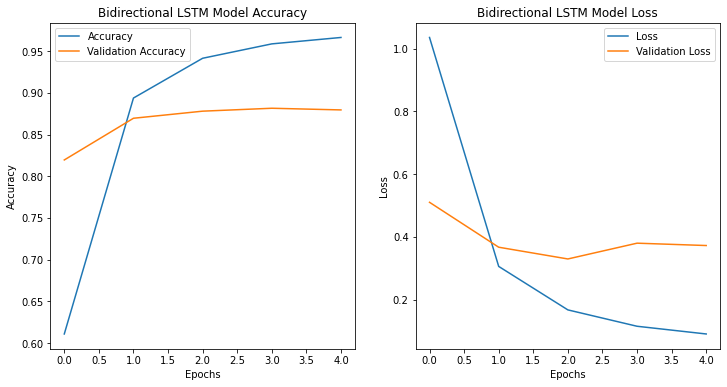

In [30]:
# Setting the figure size of the plot
plt.figure(figsize=(12,6))


# Plotting the accuracy plot of Bidirectional LSTM model
plt.subplot(1,2,1)
plt.title("Bidirectional LSTM Model Accuracy")
plt.plot(bidirectional_lstm_model_history.history['accuracy'],label='Accuracy')
plt.plot(bidirectional_lstm_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


# Plotting the loss plot of Bidirectional LSTM model
plt.subplot(1,2,2)
plt.title("Bidirectional LSTM Model Loss")
plt.plot(bidirectional_lstm_model_history.history['loss'],label='Loss')
plt.plot(bidirectional_lstm_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# # Plotting the accuracy plot of LSTM model
# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.title("LSTM Model Accuracy")
# plt.plot(lstm_model_history.history['accuracy'],label='Accuracy')
# plt.plot(lstm_model_history.history['val_accuracy'],label='Validation Accuracy')
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()

# # Plotting the loss plot of LSTM model
# plt.subplot(1,2,2)
# plt.title("LSTM Model Loss")
# plt.plot(lstm_model_history.history['loss'],label='Loss')
# plt.plot(lstm_model_history.history['val_loss'],label='Validation Loss')
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

# # Plotting the accuracy plot of Stack LSTM model
# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.title("Stack LSTM Model Accuracy")
# plt.plot(stack_lstm_model_history.history['accuracy'],label='Accuracy')
# plt.plot(stack_lstm_model_history.history['val_accuracy'],label='Validation Accuracy')
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend()

# # Plotting the loss plot of Stack LSTM model
# plt.subplot(1,2,2)
# plt.title("Stack LSTM Model Loss")
# plt.plot(stack_lstm_model_history.history['loss'],label='Loss')
# plt.plot(stack_lstm_model_history.history['val_loss'],label='Validation Loss')
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()




In [31]:
# Predicting the output of each model on test data for model evaluation
# ----------------------------------------------------------------------
y_pred_bilstm = bidirectional_lstm_model.predict(x_test)
# y_pred_lstm = lstm_model.predict(x_test)
# y_pred_stacklstm = stack_lstm_model.predict(x_test)
# y_pred_bigru = bidirectional_gru_model.predict(x_test)



# Converting the continuous output model into discrete classes
# ---------------------------------------------------------------------
y_pred_bilstm = np.array([np.argmax(x) for x in y_pred_bilstm])
y_pred_lstm = np.array([np.argmax(x) for x in y_pred_lstm])
y_pred_stacklstm = np.array([np.argmax(x) for x in y_pred_stacklstm])
y_pred_bigru = np.array([np.argmax(x) for x in y_pred_bigru])


63/63 [==============================] - 2s 15ms/step


NameError: name 'y_pred_lstm' is not defined

In [ ]:
# # Predicting the accuracy_score,f1_score,recall_score,precision_score of each model
# # Then converting all the details into dataframe


# result = {"Model Name":['Bidirectional LSTM',"LSTM","Stack LSTM"],
#          "Accuracy Score":[accuracy_score(y_test,y_pred_bilstm),accuracy_score(y_test,y_pred_lstm),accuracy_score(y_test,y_pred_stacklstm)],
#          "F1 Score(macro)":[f1_score(y_test,y_pred_bilstm,average='macro'),f1_score(y_test,y_pred_lstm,average='macro'),f1_score(y_test,y_pred_stacklstm,average='macro')],
#          "Recall Score(macro)":[recall_score(y_test,y_pred_bilstm,average='macro'),recall_score(y_test,y_pred_lstm,average='macro'),recall_score(y_test,y_pred_stacklstm,average='macro')],
#          "Precision Score(macro)":[precision_score(y_test,y_pred_bilstm,average='macro'),precision_score(y_test,y_pred_lstm,average='macro'),precision_score(y_test,y_pred_stacklstm,average='macro')],
#          "F1 Score(micro)":[f1_score(y_test,y_pred_bilstm,average='micro'),f1_score(y_test,y_pred_lstm,average='micro'),f1_score(y_test,y_pred_stacklstm,average='micro')],
#          "Recall Score(micro)":[recall_score(y_test,y_pred_bilstm,average='micro'),recall_score(y_test,y_pred_lstm,average='micro'),recall_score(y_test,y_pred_stacklstm,average='micro')],
#          "Precision Score(micro)":[precision_score(y_test,y_pred_bilstm,average='micro'),precision_score(y_test,y_pred_lstm,average='micro'),precision_score(y_test,y_pred_stacklstm,average='micro')],}

# result_df = pd.DataFrame(result)

# result_df.to_excel("Report of Trained Model.xlsx")

# display(result_df)

# 6. Predictive System to perform prediction on custom data

In [32]:
# Making a predictive function which takes the input as text and in output it provide the emotion of the text

def predict_emotion_of_text(text):

    processed_text = text_preprocess(text)
    text_to_sequence = tokenizer.texts_to_sequences([processed_text])[0]
    padded_sequence = pad_sequences([text_to_sequence],maxlen = 50, padding = 'post')

    prediction = bidirectional_lstm_model.predict(padded_sequence)[0]    # We can use any model from  above like Bidirection LSTM, LSTM, Stack LSTM, GRU, Stack GRU Or Bidirectional GRU. As the accuracy of Bidirectional is more. So in this case I have Choose this model in predictive system.

    classes = ['joy','sadness','anger','fear','love','surprise']


    print("Input: ",text)
    print("Output: ",classes[np.argmax(prediction)])
    print("\n")

In [33]:
# Testing our model output with my own custom data

predict_emotion_of_text("Today is a bad day for me")
predict_emotion_of_text("she always gets angry if she doesn't get her own way")
predict_emotion_of_text("I love myself")
predict_emotion_of_text("wow! this is amazing")
predict_emotion_of_text("That horror movie is so scary")
predict_emotion_of_text("Wow! what a lovely surprise")

1/1 [==============================] - 0s 34ms/step
Input:  Today is a bad day for me
Output:  sadness


1/1 [==============================] - 0s 34ms/step
Input:  she always gets angry if she doesn't get her own way
Output:  anger


1/1 [==============================] - 0s 35ms/step
Input:  I love myself
Output:  love


1/1 [==============================] - 0s 34ms/step
Input:  wow! this is amazing
Output:  surprise


1/1 [==============================] - 0s 34ms/step
Input:  That horror movie is so scary
Output:  fear


1/1 [==============================] - 0s 35ms/step
Input:  Wow! what a lovely surprise
Output:  surprise




In [ ]:
predict_emotion_of_text("i am very scared of darkness")

In [36]:
bidirectional_lstm_model.save('Mymodels/lstm_emotion_model3.h5')

NameError: name 'model' is not defined